In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import matplotlib.dates as mdates
from pathlib import Path
from stats import get_stats

In [2]:
df = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/insitu_uavsar_v2.parq')
snotel = df[df.datasource == 'NRCS'].copy()

wx = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/snotel.parq')
wx = wx[wx.site_name != 'jackson'].copy()

snotel.loc[:, 'end_datetime'] = pd.to_datetime(snotel.loc[:, 'end_datetime'])
snotel.loc[:, 'start_datetime'] = snotel.loc[:, 'end_datetime'] - pd.to_timedelta(snotel.loc[:, 'dTime'])

/tmp/ipykernel_26029/491213104.py:7: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  snotel.loc[:, 'end_datetime'] = pd.to_datetime(snotel.loc[:, 'end_datetime'])


/tmp/ipykernel_26029/3163364864.py:17: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  start_sd = df[r['start_datetime'].strftime('%Y-%m-%d')]['SD'].values[0]
/tmp/ipykernel_26029/3163364864.py:17: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  start_sd = df[r['start_datetime'].strftime('%Y-%m-%d')]['SD'].values[0]
/tmp/ipykernel_26029/3163364864.py:17: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  start_sd = df[r['start_datetime'].strftime('%Y-%m-%d')]['SD'].values[0]


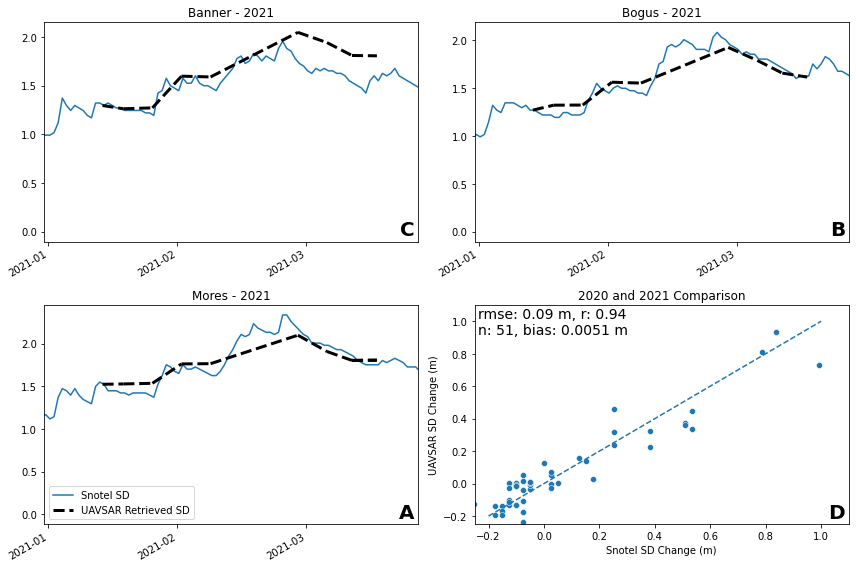

In [6]:
fig,axes = plt.subplots(2, 2, figsize = (12, 8))
inset_label = {0:'C',1:'B',2:'A'}
for inset, (site_name, df) in enumerate(wx.groupby('site_name')):
    ax = axes.ravel()[inset]
    df = df.reset_index(level = 1)
    # df = df[df.index > '2021-12-01']
    df['SD'].plot(ax = ax, label = 'Snotel SD')

    uavsar_data = snotel[snotel.site_name == site_name].drop_duplicates('end_datetime').sort_values('end_datetime')
    # uavsar_data = uavsar_data['2021-12-01' < uavsar_data.start_datetime]
    start_sd = -1
    for i, r in uavsar_data.iterrows():
        if r.start_datetime.year != 2021:
            continue
        
        if start_sd == -1:
            start_sd = df[r['start_datetime'].strftime('%Y-%m-%d')]['SD'].values[0]

        p1 = [r.start_datetime, r.end_datetime]
        p2 = [start_sd, start_sd + r['UV_int_VV_sd']]
        ax.plot(p1, p2, color = 'black', linewidth = 3, linestyle = 'dashed')
        start_sd = start_sd + r['UV_int_VV_sd']
    if inset == 2:
        ax.plot(p1, p2, color = 'black', linewidth = 3, linestyle = 'dashed', label = 'UAVSAR Retrieved SD')
        ax.legend(loc = 'lower left')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=31))
    ax.xaxis.set_tick_params(rotation = 30)  
    ax.set_xbound(date(2021, 1, 1), date(2021, 4, 1))
    ax.set_xlabel('')
    ax.set_title(f'{r.site_name.capitalize()} - 2021')
    ax.text(.99, .01, s = inset_label[inset], ha = 'right', va = 'bottom', transform = ax.transAxes, fontweight = 'bold', fontsize = 20)


ax = axes.ravel()[3]
sns.scatterplot(data = snotel, x = 'dSD', y = 'UV_int_VV_sd', ax= ax)
ax.plot([-0.2, 1], [-0.2, 1], linestyle= 'dashed')
ax.set_xlabel('Snotel SD Change (m)')
ax.set_ylabel('UAVSAR SD Change (m)')
ax.set_xlim(-0.25, 1.1)
ax.set_ylim(-0.25, 1.1)
rmse, r, n, bias = get_stats(snotel.dSD, snotel.UV_int_VV_sd, bias = True)
ax.text(.01, .99, s = f'rmse: {rmse:.2f} m, r: {r:.2}\nn: {n}, bias: {bias:.2} m', ha = 'left', va = 'top', transform = ax.transAxes, fontsize = 14)
ax.text(.99, .01, s = f'D', ha = 'right', va = 'bottom', transform = ax.transAxes, fontweight = 'bold', fontsize = 20)
ax.set_title('2020 and 2021 Comparison')
plt.tight_layout()
figdir = Path('/bsuhome/zacharykeskinen/uavsar-validation/figures/snotel')
plt.savefig(figdir.joinpath('2021-snotel-vis.png'))